In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
from tqdm.notebook import tqdm as tqdm
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

In [4]:
tf.__version__

'2.4.1'

In [5]:
file_train = "./train.csv"
file_test = "./test.csv"

df_train = pd.read_csv(file_train, dtype=str, sep=";")
df_train = df_train[df_train.incidenType != 'Demand']
df_train.shape


(6715, 4)

In [6]:
df_test = pd.read_csv(file_test, dtype=str, sep=";")
df_test = df_test[df_test.incidenType != 'Demand']

df_test.shape

(1638, 4)

In [7]:
BATCH_SIZE = 16

In [8]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

In [9]:
embed.variables[0].shape

TensorShape([7530, 512])

In [10]:
embed.variables[-1].shape

TensorShape([30])

In [11]:
len(df_train)

6715

In [ ]:
df_train.head()

In [13]:
train_embs = list()

for i in tqdm(range(0, len(df_train), BATCH_SIZE)):
    sents = df_train.fulltext[i:i+BATCH_SIZE]
    embs = embed(sents.values)
    train_embs.extend(embs)

  0%|          | 0/420 [00:00<?, ?it/s]

In [14]:
train_embs = np.array(train_embs)

In [15]:
test_embs = list()

for i in tqdm(range(0, len(df_test), BATCH_SIZE)):
    sents = df_test.fulltext[i:i+BATCH_SIZE]
    embs = embed(sents.values)
    test_embs.extend(embs)

  0%|          | 0/103 [00:00<?, ?it/s]

In [16]:
test_embs = np.array(test_embs)

In [17]:
print(train_embs)

[[-0.01947508 -0.06508407  0.01517708 ...  0.03814196 -0.00215398
   0.05377458]
 [-0.02983331 -0.0109236   0.01839796 ... -0.08993277 -0.09339771
   0.02692392]
 [ 0.02031167 -0.00850745 -0.03154376 ... -0.10013221 -0.09420305
  -0.0240118 ]
 ...
 [ 0.02424421  0.06023957  0.05919204 ... -0.07531951 -0.07150269
  -0.01709905]
 [ 0.02729269  0.07172837  0.06352988 ... -0.01075677 -0.02077922
   0.06658051]
 [-0.05857463  0.00777591  0.03781514 ...  0.01387861 -0.01733831
   0.05084124]]


In [18]:
print(type(train_embs))
X = train_embs

<class 'numpy.ndarray'>


In [19]:
db = DBSCAN(eps=0.5, min_samples=5).fit(X)


In [20]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [21]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [22]:
print('Estimated number of clusters: %d' % n_clusters_)
#print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 32
Estimated number of noise points: 5848


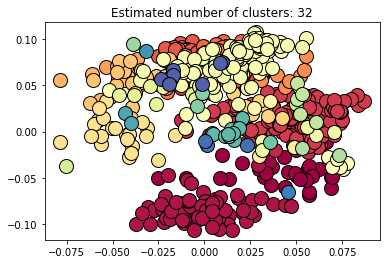

In [23]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    #xy = X[class_member_mask & ~core_samples_mask]
    #plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
    #         markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [24]:
model = LogisticRegression(solver='liblinear')


In [25]:
x_train, y_train, x_test, y_test = train_embs, df_train.incidenType, test_embs, df_test.incidenType

In [26]:
model.fit(x_train, y_train)
preds = model.predict(x_test)
print((y_test.value_counts() / len(y_test)), '\n')
print(classification_report(y_test, preds))

Request     0.69536
Incident    0.30464
Name: incidenType, dtype: float64 

              precision    recall  f1-score   support

    Incident       0.82      0.65      0.73       499
     Request       0.86      0.94      0.90      1139

    accuracy                           0.85      1638
   macro avg       0.84      0.80      0.81      1638
weighted avg       0.85      0.85      0.85      1638



In [28]:
#with open('test_embs_large.npy', 'wb') as f:
#    np.save(f, test_embs)

In [29]:
#with open('train_embs_large.npy', 'rb') as f:
#    train_embs1 = np.load(f)
